In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from tdnn import TDNN
from learning import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float32) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float32)

# 4000 tr, 1000 val, 5000 test
train_x, test_x = x_data[:5000], x_data[5000:]
train_y, test_y = y_data[:5000], y_data[5000:]

train_x, val_x = train_x[:4000], train_x[4000:]
train_y, val_y = train_y[:4000], train_y[4000:]

In [67]:
window_size = 10

train_data = SequenceDataset(train_x, train_y, window_size)
train_loader = data.DataLoader(train_data, batch_size=500, shuffle=False)

val_data = SequenceDataset(val_x, val_y, window_size)
val_loader = data.DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [72]:
def train_model(model, train_loader, val_loader, loss, optimizer, epochs, verbose=True):
    #tdnn = TDNN(window_size, 64, 1).to(device)
    loss = torch.nn.MSELoss()
    mae_loss = torch.nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    epochs = 20
    verbose = True

    train_mse_history = []
    val_mse_history = []

    for epoch in range(epochs):

        model.train() # set to training mode
        train_mse = 0
        for x, y in train_loader:
            optimizer.zero_grad() # zero the gradients

            out = model(x)
            train_loss = loss(out, y.unsqueeze(1))

            train_loss.backward()
            optimizer.step()

            train_mse += train_loss.item()
        
        train_mse /= len(train_loader) # average the loss over the minibatches (number of minbatch given by 'len(train_loader)')
        
        model.eval() # set to evaluation mode
        with torch.no_grad(): # no need to compute gradients (more efficient)
            for x, y in val_loader:
                out = model(x)
                val_mse = loss(out, y.unsqueeze(1))
                val_mae = mae_loss(out, y.unsqueeze(1))
        
        train_mse_history.append(train_mse)
        val_mse_history.append(val_mse.item())
        if verbose:
            print(f'Epoch {epoch} - Train MSE: {train_mse} - Val MSE: {val_mse.item()} - Val MAE: {val_mae.item()}')

    return train_mse_history, val_mse_history


Epoch 0 - Train MSE: 0.12040088325738907 - Val MSE: 0.11130627244710922 - Val MAE: 0.32115915417671204
Epoch 1 - Train MSE: 0.11236899346113205 - Val MSE: 0.10368750244379044 - Val MAE: 0.30910128355026245
Epoch 2 - Train MSE: 0.10464471578598022 - Val MSE: 0.09637443721294403 - Val MAE: 0.2970640957355499
Epoch 3 - Train MSE: 0.0972299575805664 - Val MSE: 0.08937010914087296 - Val MAE: 0.28505566716194153
Epoch 4 - Train MSE: 0.09012777358293533 - Val MSE: 0.08267779648303986 - Val MAE: 0.2730858325958252
Epoch 5 - Train MSE: 0.08334150165319443 - Val MSE: 0.07630008459091187 - Val MAE: 0.26116493344306946
Epoch 6 - Train MSE: 0.076873779296875 - Val MSE: 0.07023864984512329 - Val MAE: 0.2493036538362503
Epoch 7 - Train MSE: 0.07072634994983673 - Val MSE: 0.06449436396360397 - Val MAE: 0.2375127673149109
Epoch 8 - Train MSE: 0.06490007042884827 - Val MSE: 0.05906720831990242 - Val MAE: 0.22580350935459137
Epoch 9 - Train MSE: 0.05939493700861931 - Val MSE: 0.05395638942718506 - Val MA

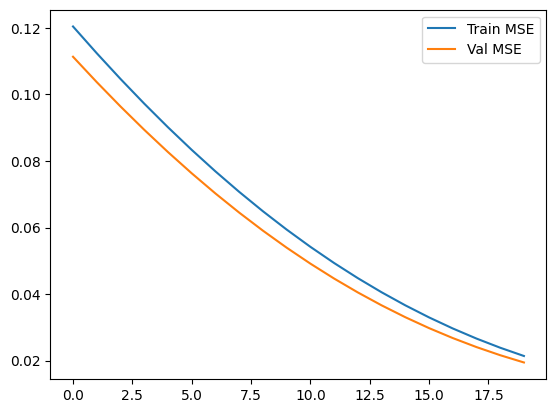

In [73]:
# this code is just a try to see how to plot
plt.plot(train_mse_history, label='Train MSE')
plt.plot(val_mse_history, label='Val MSE')
plt.legend()

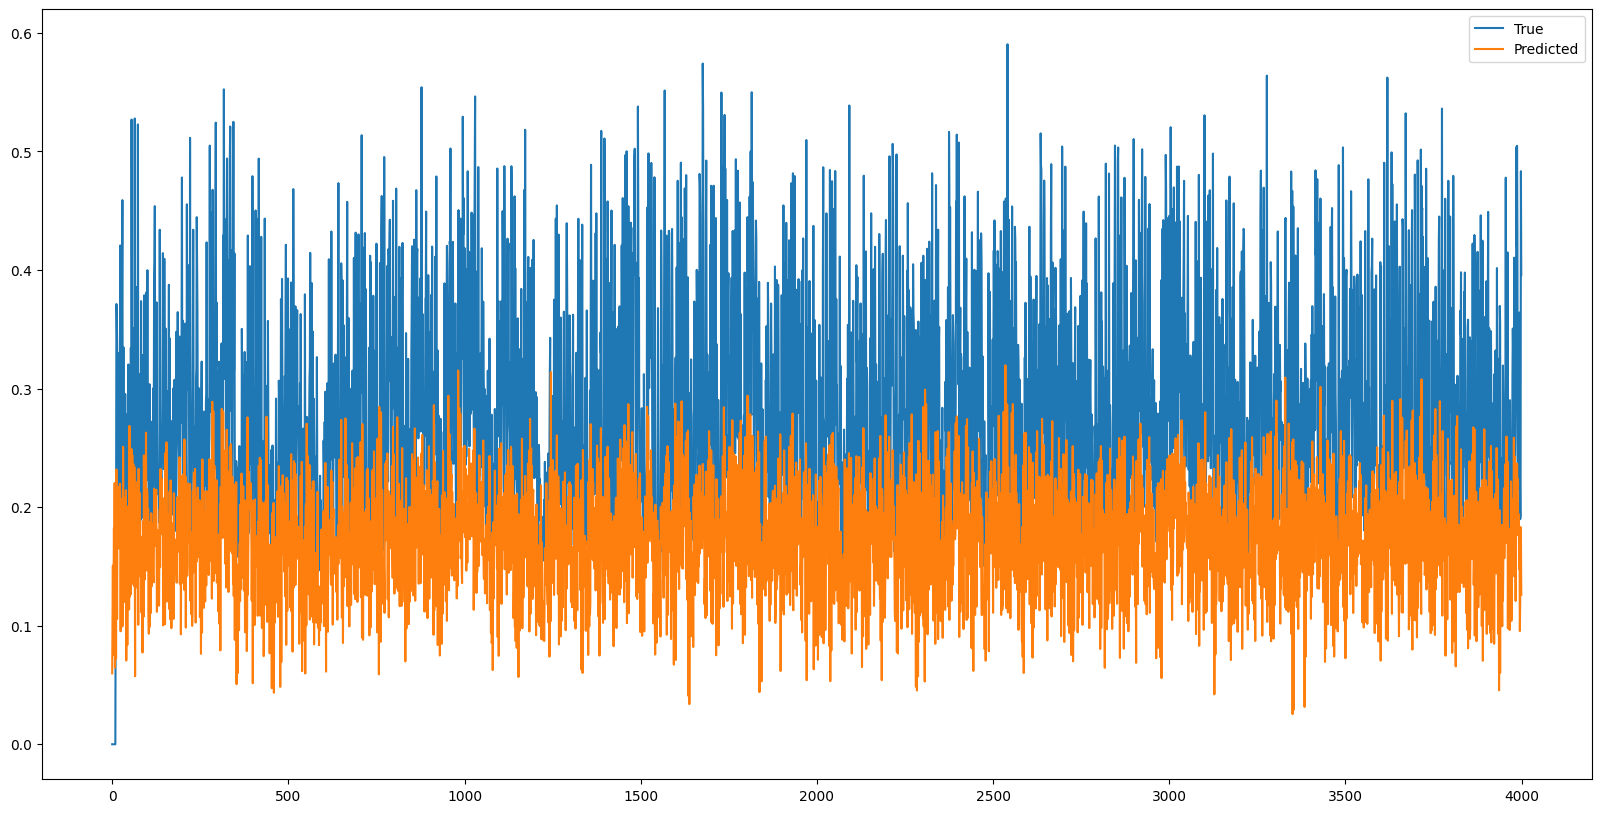

In [74]:
# this code is just a try to see how to plot
train_loader = data.DataLoader(train_data, batch_size=len(train_data), shuffle=False)
plt.figure(figsize=(20, 10))
for x, y in train_loader:
    with torch.no_grad():
        out = tdnn(x)
        plt.plot(y.cpu().numpy(), label='True')
        plt.plot(out.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.show()